# Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score,classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from pandas import DataFrame,Series

# Read datasets

In [3]:
fraud_df = pd.read_csv("Fraud_Data.csv")
ISP_df = pd.read_csv("IpAddress_to_Country.csv")


# fraud_df table
checking datatypes in fraud_df

In [4]:
fraud_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

checking null values in fraud_df

In [5]:
print("Check for null values")
for col in fraud_df.columns:
    print("# of null values in {}: {}".format(col, fraud_df[col].isnull().sum()))

Check for null values
# of null values in user_id: 0
# of null values in signup_time: 0
# of null values in purchase_time: 0
# of null values in purchase_value: 0
# of null values in device_id: 0
# of null values in source: 0
# of null values in browser: 0
# of null values in sex: 0
# of null values in age: 0
# of null values in ip_address: 0
# of null values in class: 0


Finally, look at some descriptive stats

In [6]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


# ISP_df
checking datatypes in ISP_df

In [7]:
ISP_df.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

It's not clear whether the lower bound for the ip address is actually a float, i.e., has non-zero decimals, or is just an integer with a zero decimal.

In [8]:
ip_floats = ISP_df.lower_bound_ip_address.apply(lambda x: not x.is_integer()).sum()
print("Number of non-zero decimal ip address lower bounds: {}".format(ip_floats))

Number of non-zero decimal ip address lower bounds: 0


It's just a bunch of integers with zero decimals so I'll convert the entire series to int64.

In [9]:
ISP_df.lower_bound_ip_address = ISP_df.lower_bound_ip_address.astype(int)

checking null values in ISP_df

In [10]:
print("Check for null values")
for col in ISP_df.columns:
    print("# of null values in {}: {}".format(col, ISP_df[col].isnull().sum()))

Check for null values
# of null values in lower_bound_ip_address: 0
# of null values in upper_bound_ip_address: 0
# of null values in country: 0


Finally, look at some descriptive stats

In [11]:
ISP_df.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,-1.214785e+09,2.724557e+09
std,1.563396e+09,8.974979e+08
min,-2.147484e+09,1.677747e+07
25%,-2.147484e+09,1.920008e+09
50%,-2.147484e+09,3.230888e+09
75%,5.228780e+08,3.350466e+09
max,2.113929e+09,3.758096e+09


# Mapping IP_address to Country
Adding a country column in fraud_df table by comparing the ip_address in fraud_df table to lowerbound ip_address and upper bound ip_address in ISP_df table.

For corresponding ip_address if country found within the bounds of ip_address then respective "country" will be displayed else "Missing" will be displayed.

In [12]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.lower_bound_ip_address <= ip) 
                    & (ISP_df.upper_bound_ip_address >= ip) ].country
    if tmp_ser.shape[0] > 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return "Missing"
    elif tmp_ser.shape[0] == 1:
        return "Error"
    
fraud_df["country"] = fraud_df.ip_address.apply(ip_to_country)


Displaying fraud_df table in order to look at the following changes.

The raw fraud dataset now has all desired columns.

This completes the first task of the challenge.

In [13]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Before going forward, I'll save this version of the fraud dataset for quicker load times.

In [14]:
fraud_df.to_csv("Fraud_Data_with_Countries.csv")

# Basic visualizations

Let's,explore the correlation between sex and class. Males make up more of the customer base of the company and thus are also involved in more of the fraud cases. It doesn't look like one gender is more likely to participate in fraud though, just that one gender tends to use the site more in general.

Text(0, 0.5, 'Counts')

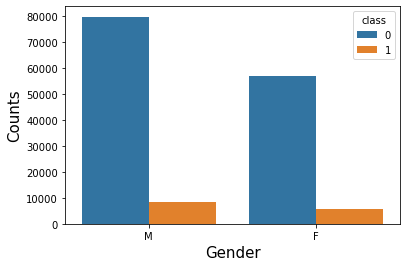

In [15]:
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between browser used and fraud. Again, the browser counts seem to be more indicative of their relative overall popularity rather than any meaningful trend associated with fraud.

Text(0, 0.5, 'Counts')

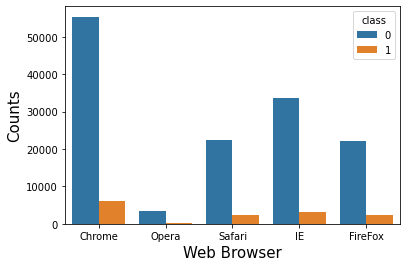

In [16]:
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, we explore the relationship between marketing source and fraud. It doesn't look like any given marketing source is more associated with fraud either.

Text(0, 0.5, 'Counts')

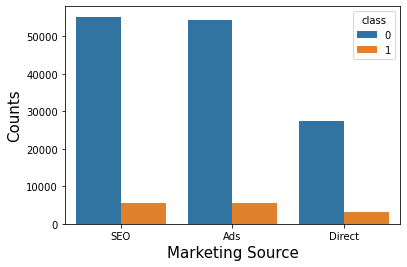

In [17]:
sns.countplot(x='source', hue='class', data=fraud_df)
plt.xlabel("Marketing Source", fontsize=15)
plt.ylabel("Counts", fontsize=15)

 Next,we write a function that is used to seperate both the fradulent and non fradulent activities.


 As the values in age and purchase value are more hence we are seperating both the fraud and non fraud activities with respect to the class



Next, I explore the relationship between age and fraud.
Here we are exploring both fraud and non fraud actvities seperately.
We can see clearly that fraudulent activities are between the age of 28-39 

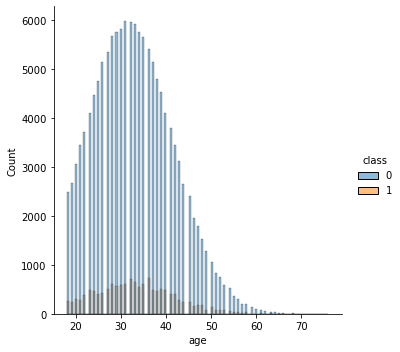

In [18]:
sns.displot(fraud_df, x="age", hue="class")

Next, I explore the relationship between purchase value and fraud.

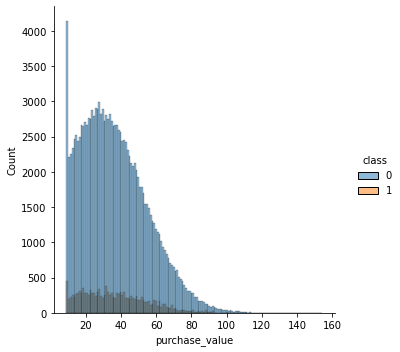

In [19]:
sns.displot(fraud_df, x="purchase_value", hue="class")

Next, I explore the relationship between country of origin and fraud. It's impossible to represent 250+ countries in a visually nice way. Below, I display a bar chart showing the share of anomalous instances each country is responsible for fraud.





We can tell that fraud happened more in United States , Missing.

Text(0, 0.5, 'Fraud')

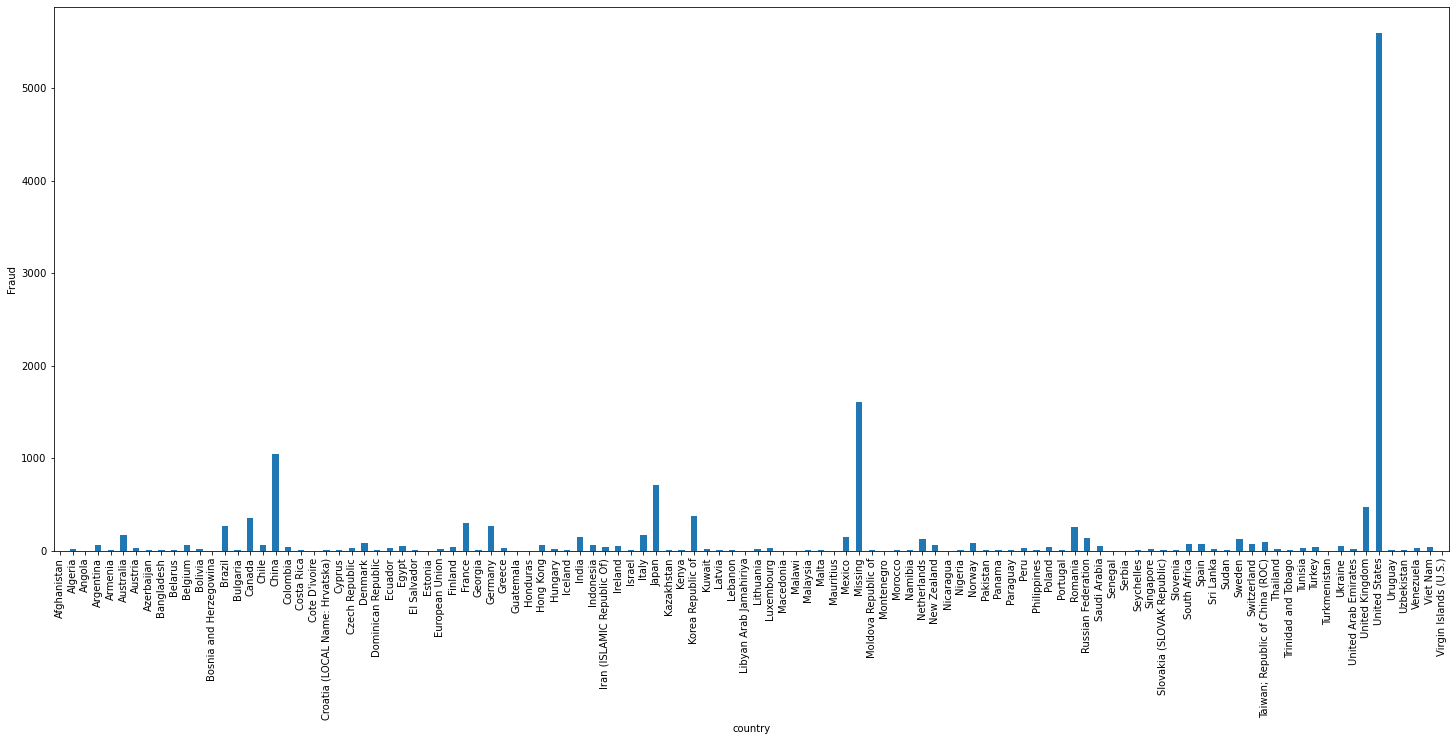

In [20]:
fig, ax = plt.subplots(1,1,figsize=(25,10),sharey=True)
x=(fraud_df[fraud_df["class"] == 1]["class"].groupby(fraud_df.country).sum())
x.plot(kind='bar')
plt.ylabel('Fraud')

Next, I explore the relationship between the number of unique user ids assocated with a single device. It is clearly important correlations. It seems that multiple user ids associated with  a unique device id  is a large indicator of fraudulent behaviour.

In [21]:
device_user_count = len(fraud_df) * [0]
device_count = fraud_df.groupby('device_id')['user_id'].count()
device_user_count = device_count[fraud_df['device_id']]
device_user_count = device_user_count.reset_index().drop('device_id', axis = 1)
device_user_count.columns = ['device_user_count']
fraud_df= pd.concat([fraud_df, device_user_count], axis = 1)

C:\Users\Admin\.conda\envs\mlprog1\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.424999999999997, 0.5, 'User ids per Device')

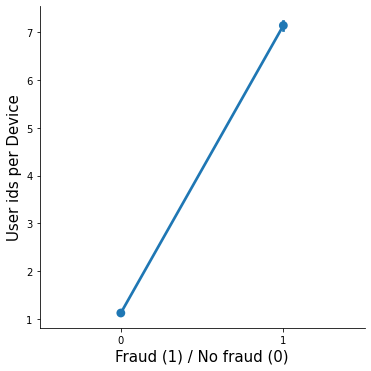

In [22]:
sns.factorplot(x="class", y="device_user_count", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per Device", fontsize=15)

Next, I explore the relationship between the number of unique user ids assocated with a single ip address. These are clearly important correlations. It seems that multiple user ids associated with either a unique ip address is a large indicator of fraudulent behaviour.

In [23]:
ip_count = fraud_df.groupby('ip_address')['user_id'].count()
ip_count = ip_count[fraud_df['ip_address']].reset_index().drop('ip_address', axis = 1)
ip_count.columns = ['ip_count']
fraud_df = pd.concat([fraud_df, ip_count], axis = 1)

C:\Users\Admin\.conda\envs\mlprog1\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.424999999999997, 0.5, 'User ids per IP Address')

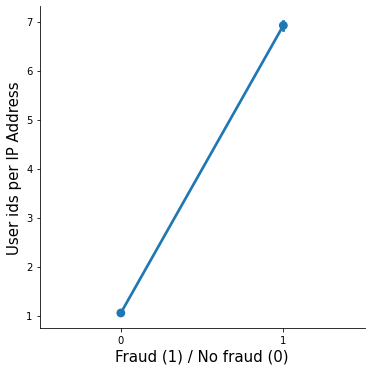

In [24]:
sns.factorplot(x="class", y="ip_count", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per IP Address", fontsize=15)


Finally, I explore the relationship between the time between sign-up and purchase time with fraud. These are also very clearly important correlations. Extremely small time periods between sign-up and purchase are also strongly correlated with fraud.

In [25]:
#Converting signup time and purchase time to datetime objects
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
#Finding difference between purchase time and signup time in seconds
fraud_df['diff_time'] = (fraud_df['purchase_time'] - fraud_df['signup_time'])/np.timedelta64(1, 's')

C:\Users\Admin\.conda\envs\mlprog1\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(6.799999999999997, 0.5, 'Sign-up to Purchase Time (Seconds)')

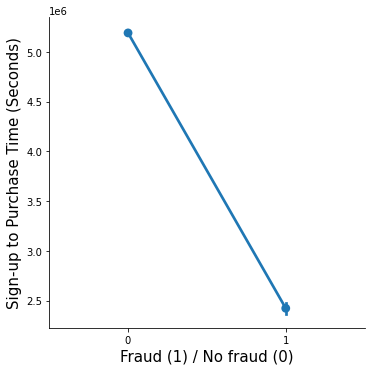

In [26]:
sns.factorplot(x="class", y="diff_time", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)

As we are working with signup and purchase time we also have day-month-year associated with sign-up and purchase time.

Hence we are creating a dummy table of the Fraud_Data table and we are not working with fraud_df table inorder to use the table in machine learning process.



We are just visualizing the fraud happened with respect to year,month,weekday,hour.
And we are not applying this changes to the real table as it makes confusion and difficult to work in future.

In [27]:
dataset=pd.read_csv("Fraud_Data.csv")


In [28]:
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')
# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# We add features 

# --- 1 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 2 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 3 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 4 ---
# period_of_the_day
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )





Dummy table(dataset)

In [29]:
dataset.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,month_purchase,weekday_purchase,hour_of_the_day,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,April,Saturday,2,late night
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,June,Monday,1,late night
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,January,Thursday,18,arvo
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,May,Monday,13,early arvo
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,September,Wednesday,18,arvo


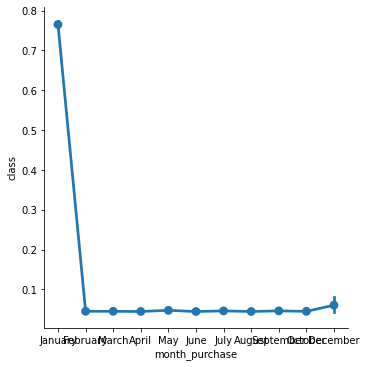

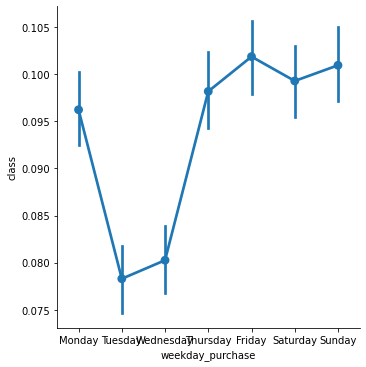

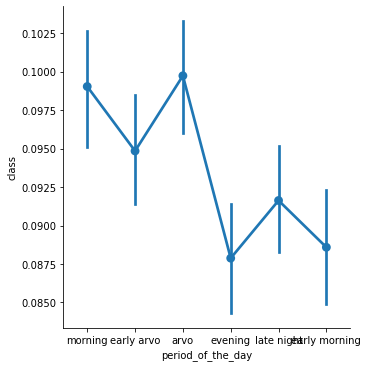

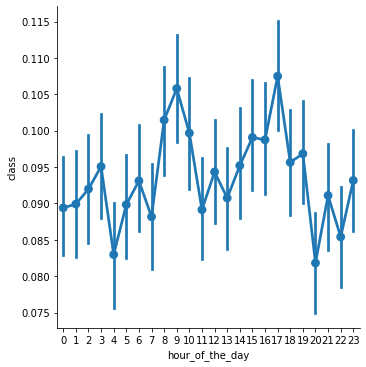

In [30]:
liste_col = [ "month_purchase","weekday_purchase", "period_of_the_day","hour_of_the_day" ]



param_order = {
              "month_purchase":["January", "February", "March", "April","May", "June", "July", "August", "September", "October", "December"],
"weekday_purchase" : ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                      "period_of_the_day" : ["morning", "early arvo", "arvo", "evening", "late night", "early morning",
                                          ]          
}




for i, colonne in enumerate(liste_col) :
    sns.factorplot(x =colonne, y = "class", data = dataset, order= param_order.get(colonne))
   


This is the final data on which we are going to work in future.

In [31]:
fraud_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_user_count,ip_count,diff_time
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing,1,1,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,4361461.0


# Un-Balanced data

In [32]:
fraud_df.to_csv('im3.csv')
im3 = pd.read_csv('im3.csv')
im3 = im3.drop('Unnamed: 0', axis = 1)

In [33]:
y = im3['class']

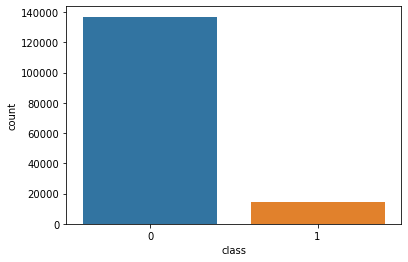

In [34]:
sns.countplot(x='class', data=fraud_df)

In [35]:
im3 = im3.drop(['user_id', 'signup_time','purchase_time','class'], axis = 1)
X = im3
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
X['device_id'] = lb.fit_transform(X['device_id'])
X['source'] = lb.fit_transform(X['source'])
X['browser'] = lb.fit_transform(X['browser'])
X['sex'] = lb.fit_transform(X['sex'])
X['country'] = lb.fit_transform(X['country'])

In [36]:
Xi_train, Xi_test, yi_train, yi_test = train_test_split(X, y, test_size = .3, random_state = 1)

# Under Sampling the Data

In [37]:
fraud_df.to_csv('us.csv')
us = pd.read_csv('us.csv')
us = us.drop('Unnamed: 0', axis = 1)

In [38]:
minority_class_len = len(us[us['class'] == 1])
print(minority_class_len)

14151


In [39]:
majority_class_len = len(us[us['class'] == 0])
print(majority_class_len)

136961


In [40]:
y1=us['class']

In [41]:
us = us.drop(['user_id', 'signup_time','purchase_time','class'], axis = 1)
X1 = us
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
X1['device_id'] = lb.fit_transform(X1['device_id'])
X1['source'] = lb.fit_transform(X1['source'])
X1['browser'] = lb.fit_transform(X1['browser'])
X1['sex'] = lb.fit_transform(X1['sex'])
X1['country'] = lb.fit_transform(X1['country'])

In [42]:
nm=NearMiss()

In [43]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X1, y1, test_size = .3, random_state = 1)

In [44]:
X_res,y_res=nm.fit_sample(Xu_train,yu_train)

In [45]:
from collections import Counter
print("before under:",Counter(yu_train))
print("after under:",Counter(y_res))

before under: Counter({0: 95968, 1: 9810})
after under: Counter({0: 9810, 1: 9810})


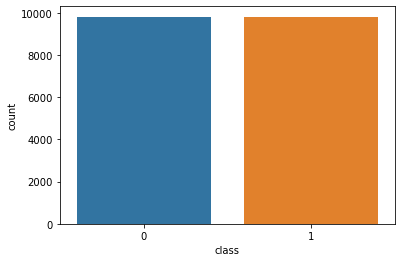

In [46]:
sns.countplot(x=y_res, data=us)

# Over Sampling

In [47]:
fraud_df.to_csv('lar.csv')
lar= pd.read_csv('lar.csv')
lar = lar.drop('Unnamed: 0', axis = 1)


In [48]:
y63 = lar['class']
lar= lar.drop(['user_id', 'signup_time','purchase_time','class'], axis = 1)
X63 =lar
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
X63['device_id'] = lb.fit_transform(X63['device_id'])
X63['source'] = lb.fit_transform(X63['source'])
X63['browser'] = lb.fit_transform(X63['browser'])
X63['sex'] = lb.fit_transform(X63['sex'])
X63['country'] = lb.fit_transform(X63['country'])

In [49]:
sm = SMOTE()

In [50]:
Xop_train, Xop_test, yop_train, yop_test = train_test_split(X63, y63, test_size = .3, random_state = 1)

In [51]:
scalar=StandardScaler()
Xop_train_scaled=scalar.fit_transform(Xop_train)
Xop_test_scaled=scalar.transform(Xop_test)

In [52]:
Xop_train_smote,yop_train_smote=sm.fit_sample(Xop_train_scaled,yop_train)

In [53]:
import collections
print("before smote:",collections.Counter(yop_train))
print("after smote:",collections.Counter(yop_train_smote))

before smote: Counter({0: 95968, 1: 9810})
after smote: Counter({0: 95968, 1: 95968})


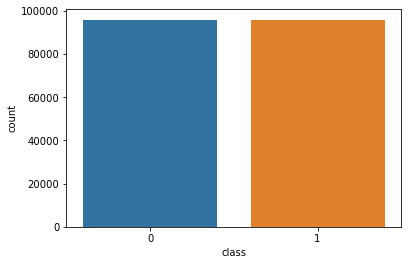

In [54]:
sns.countplot(x=yop_train_smote, data=us)

# Testing Random Forest algorithm on unbalanced,undersample,oversample data

In [55]:
classifier= RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
imbalanced=classifier.fit(Xi_train, yi_train)
y_pred = imbalanced.predict(Xi_test)
print("imbalanced data")
print("Accuracy =",accuracy_score(yi_test,y_pred))

imbalanced data
Accuracy = 0.9546918427670181


In [56]:
undersampling=classifier.fit(X_res,y_res)
y_pred1 = undersampling.predict(Xu_test)
print("under sampling")
print("Accuracy =",accuracy_score(yu_test, y_pred1))

under sampling
Accuracy = 0.8369215158600609


In [57]:
classifier111=RandomForestClassifier(n_estimators=10,random_state=5,criterion='entropy')
RF=classifier111.fit(Xop_train_smote,yop_train_smote)
y_pred63= RF.predict(Xop_test_scaled)
print("Over Sampling")
print("Accuracy=",accuracy_score(yop_test, y_pred63))


Over Sampling
Accuracy= 0.950236025940795


# Unbalanced data:(Disadvantage)


Though we get a good accuracy by imbalanced data but the data is prone to imbalance in more non
fraud compared to fraud
data hence we need to discard imbalancing accuracy


# Undersampling:(Disadvantage)
It can discard potentially useful information which could be important for building rule classifiers. The
sample chosen by under
sampling may be a biased sample. And it will not be an accurate representative of the population.
Thereby, resulting in
inaccurate results with the actual test data set.

# MODELLING
## Oversampling:

1)RANDOM FOREST CLASSIFIER

In [58]:
classifier111 = RandomForestClassifier()
RF=classifier111.fit(Xop_train_smote,yop_train_smote)
y_pred63 = RF.predict(Xop_test_scaled)
print("Accuracy =  ", accuracy_score(yop_test, y_pred63))

Accuracy =   0.9520007058719725


2)LOGISTIC REGRESSION

In [59]:
classifier112 = LogisticRegression()
LR=classifier112.fit(Xop_train_smote,yop_train_smote)
y_pred64 = LR.predict(Xop_test_scaled)
print("Accuracy = " , accuracy_score(yop_test, y_pred64))

Accuracy =  0.912780694401553


3)DECISION TREE CLASSIFIER

In [60]:
classifier113 = DecisionTreeClassifier()
DT=classifier113.fit(Xop_train_smote,yop_train_smote)
y_pred65 = DT.predict(Xop_test_scaled)
print("Accuracy = " , accuracy_score(yop_test, y_pred65))

Accuracy =  0.9038249437508272


## Accuracy of all the algorithms

Text(0, 0.5, 'accuracy')

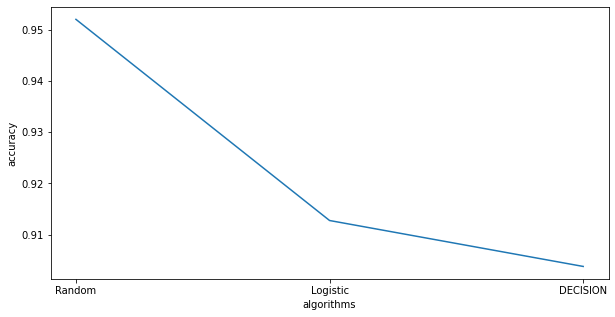

In [65]:
data = {'Random':accuracy_score(yop_test, y_pred63), 'Logistic':accuracy_score(yop_test, y_pred64), 
        'DECISION':accuracy_score(yop_test, y_pred65),  
        } 
courses = list(data.keys()) 
values = list(data.values()) 
   
fig = plt.figure(figsize = (10, 5))
plt.plot(courses, values)
plt.xlabel('algorithms')
plt.ylabel('accuracy')


## Highest Accuracy is for Random Forest Classifier
As we have got good accuracy for random forest classifier we are futher dealing with random forest classifier.

CONFUSION MATRIX AND PRECISION AND RECALL FOR RANDOM FOREST TREE

In [66]:
cm3 = confusion_matrix(yop_test,y_pred63 )
print("CONFUSION MATRIX")
print(cm3)


CONFUSION MATRIX
[[40694   299]
 [ 1877  2464]]


In [67]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
pass


In [68]:
generate_model_report(yop_test,y_pred63)

Accuracy =  0.9520007058719725
Precision =  0.8917842924357582
Recall =  0.5676111495047225
F1 Score =  0.6936936936936937


In [69]:
import numpy as np
def predict_threshold (model,X_test,thresholds):
    return np.where(model.predict_proba(X_test)[:,1]>thresholds,1,0)


In [70]:
for thr in np.arange(0,1.1,0.1):
    y_predict = predict_threshold(classifier111,Xop_test_scaled,thr)
    print("Threshold :",thr)
    print(confusion_matrix(yop_test,y_predict))


Threshold : 0.0
[[ 1097 39896]
 [   24  4317]]
Threshold : 0.1
[[30545 10448]
 [  980  3361]]
Threshold : 0.2
[[37446  3547]
 [ 1295  3046]]
Threshold : 0.30000000000000004
[[39336  1657]
 [ 1513  2828]]
Threshold : 0.4
[[40214   779]
 [ 1733  2608]]
Threshold : 0.5
[[40694   299]
 [ 1877  2464]]
Threshold : 0.6000000000000001
[[40898    95]
 [ 1971  2370]]
Threshold : 0.7000000000000001
[[40966    27]
 [ 1990  2351]]
Threshold : 0.8
[[40987     6]
 [ 1999  2342]]
Threshold : 0.9
[[40991     2]
 [ 2003  2338]]
Threshold : 1.0
[[40993     0]
 [ 4341     0]]


In [71]:
prob = classifier111.predict_proba(Xop_test_scaled)[:,1]
prob[prob > 0.1] = 1
prob[prob <= 0.1] = 0


In [72]:
 cmp = confusion_matrix(yop_test, prob)
print("CONFUSION MATRIX")
print(cmp)


CONFUSION MATRIX
[[30545 10448]
 [  980  3361]]


In [73]:
generate_model_report(yop_test, prob)

Accuracy =  0.7479154718312966
Precision =  0.24339199073068288
Recall =  0.7742455655378945
F1 Score =  0.37035812672176305
